In [1]:
#### 12-08-2022 
####
#### J Stedehouder/D Brizee
####
#### FSCV Complete Analysis
####
#### Runs the preprocessing and consequent analysis of raw .abf files
####
#### Input:
#### - Folder with raw .abf files named for example "2021_08_03_001.abf"
#### - Calibration value
#### 
#### Output:
#### - PDF file with 'raw' voltammogram plots
#### - Processed .csv file named "'InverseDate'.'SliceNumber'.Data.csv" (similar to would come out of axoscope)
#### - PDF file with individual transients
#### - PDF file with aligned transients
#### - Processed .csv file named "'InverseDate'.'SliceNumber'.DataProcessed.csv"
####
#### -----------------
#### Updates since v7:
#### - Removed slice number from datafile names
#### - Added transient length to output file names
#### - Tranposed output file
#### - Transient length to voltammogram plots
#### - Removed commented lines of code
#### - Fixed the zero problem so 009-010 and 099-100 transitions now work
####
####

In [5]:
## Import libraries & set directories

import pandas as pd                # Imports all required libraries for this code to run
import numpy as np
import matplotlib.pyplot as plt
import os 
import pyabf

%matplotlib inline

homeDir = '/Users/xxxxxxx/Documents/Projects/xxxxxxxxx/Code/'      
    # Directory containing Python code; Alter to fit your own folder organization!

dataDir = '/Volumes/xxxxxxx/to analyse/' 
    # Directory containing raw datafiles; Alter to fit your own folder organization!

procDir = '/Users/xxxxxxxxx/Documents/Projects/xxxxxxxxxx/Code/Data Testing'
    # Directory containing output location; Alter to fit your own folder organization!


1.4608765
[208]
54
600


Text(0, 0.5, 'nA')

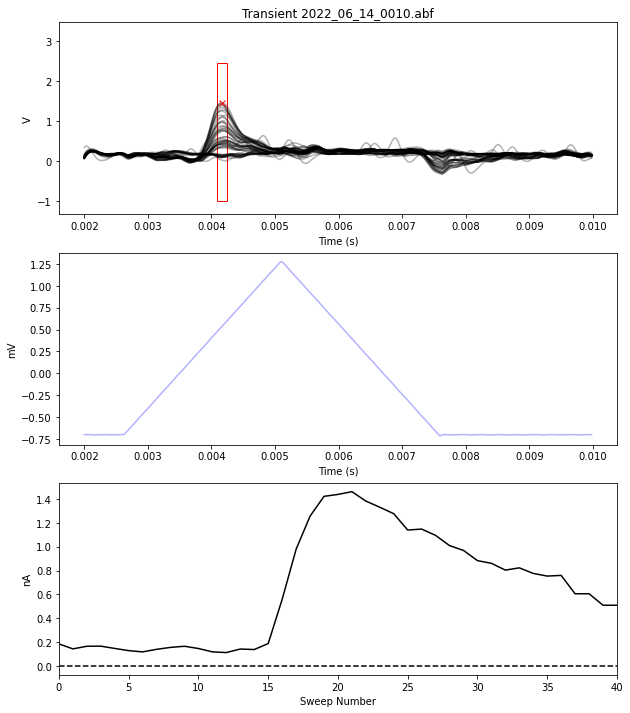

In [36]:
## Plot EXAMPLE raw FSCV trace, extract peaks, plot transient

DataFolder = "20220614"
ExtendedDate = "2022_06_14_"

TransientNumber = "10"

## Load data

zeros = "0000" # Fill 0's data number

os.chdir(dataDir)

DataName = ExtendedDate+zeros[len(str(TransientNumber)):]+str(TransientNumber)+".abf"

abf = pyabf.ABF(DataFolder+"/"+DataName)

w, h = 10,4
ncols = 1
nrows = 3
plt.figure(figsize = (ncols*w, nrows*h))

PeakWindow = 4

Peaks = [] ; Troughs = []

plt.subplot(nrows, ncols, 1)
for x in range(0,abf.sweepCount):
    abf.setSweep(sweepNumber=x, channel=1)
    plt.plot(abf.sweepX[100:500], abf.sweepY[100:500], 'k', alpha=0.3)
    Peak=np.max(abf.sweepY[100:500])
    Peaks.append(Peak)
    Trough=np.min(abf.sweepY[100:500])
    Troughs.append(Trough)
plt.title('Transient '+str(DataName))
plt.xlabel('Time (s)')
plt.ylabel('V')
print(np.max(Peaks))

PeakSweepNumber = np.where(Peaks==np.max(Peaks))[0]
abf.setSweep(sweepNumber=PeakSweepNumber[0], channel=1)
PeakIndex = np.where(abf.sweepY[100:500]==np.max(Peaks))[0]+100
print(PeakIndex)

plt.plot(abf.sweepX[PeakIndex],np.max(Peaks),'x', color = 'r')
plt.vlines(abf.sweepX[PeakIndex-PeakWindow],-1,np.max(Peaks)+1,color='r',linestyles='solid',linewidths = 1)
plt.vlines(abf.sweepX[PeakIndex+PeakWindow],-1,np.max(Peaks)+1,color='r',linestyles='solid',linewidths = 1)
plt.hlines(-1,abf.sweepX[PeakIndex-PeakWindow],abf.sweepX[PeakIndex+PeakWindow],color='r',linestyles='solid',linewidths = 1)
plt.hlines(np.max(Peaks)+1,abf.sweepX[PeakIndex-PeakWindow],abf.sweepX[PeakIndex+PeakWindow],color='r',linestyles='solid',linewidths = 1)

plt.ylim([np.min(Troughs)-1,np.max(Peaks)+2])

plt.subplot(nrows, ncols, 2)
abf.setSweep(sweepNumber=1, channel=0)
plt.plot(abf.sweepX[100:500], abf.sweepY[100:500], 'b', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('mV')

RefinedPeaks = []
for x in range(0,abf.sweepCount):
    abf.setSweep(sweepNumber=x, channel=1)
    RefinedPeak=np.max(abf.sweepY[PeakIndex[0]-PeakWindow:PeakIndex[0]+PeakWindow])
    RefinedPeaks.append(RefinedPeak)

print(len(RefinedPeaks))
print(len(abf.sweepX))

plt.subplot(nrows, ncols, 3)
plt.plot(RefinedPeaks, 'k')
plt.hlines(0, 0, len(RefinedPeaks), color = 'k', linestyle = 'dashed')
plt.xlim([0,40])
plt.xlabel('Sweep Number')
plt.ylabel('nA')


In [38]:
## Provide experiment info

DataFolder = input('What is the data folder name (=inverse date)? ')
Start_file = int(input('What is the first file number of the list? '))
End_file = int(input('What is the last file number of the list? '))+1
Exclusion_file = int(input('What number would you like to exclude? ')) #Write 999 if none
Slice_name = input('What is the slice number? ')
Experiment_title = input('Please provide experiment title: ')
Calibration = float(input('Please enter calibration value: ')) 


What is the data folder name (=inverse date)? 20220614
What is the first file number of the list? 9
What is the last file number of the list? 11
What number would you like to exclude? 999
What is the slice number? I
Please provide experiment title: Test
Please enter calibration value: 2.5


Analysing: 2022_06_14_0009.abf
Analysing: 2022_06_14_0010.abf
Analysing: 2022_06_14_0011.abf
...Done... 
Saved 2022_06_14_0.I.Data.csv


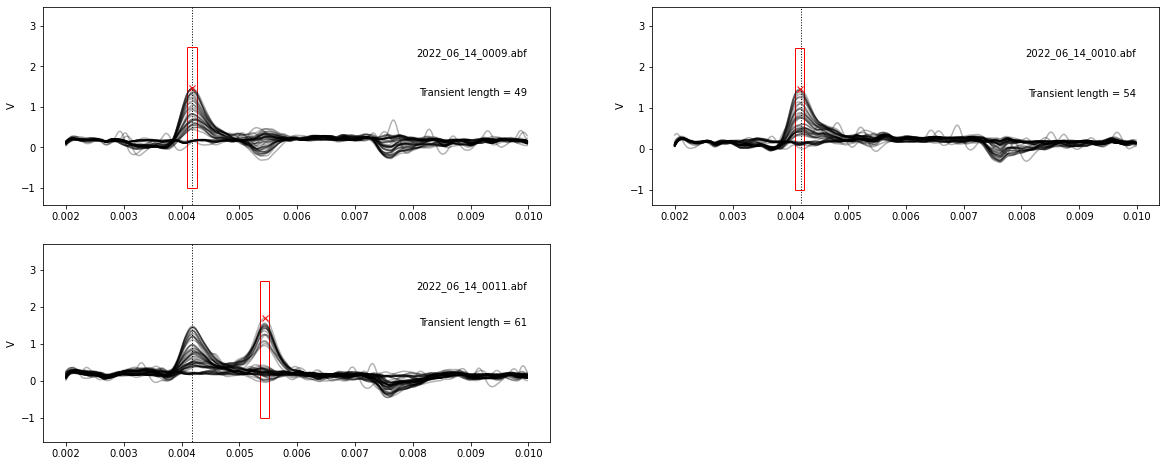

In [39]:
## Run full preprocessing

PeakWindow = 4

abfs = [] ; filenames = [] ; DataNames = []

st = 100
en = 500

ncols = 2
nrows = int((End_file-Start_file)/ncols)+1

zeros = "0000" #fill 0's data number

plt.figure(figsize=(10*ncols, 4*nrows))
for Trnsnmbi, TransientNumbers in enumerate(range(Start_file,End_file)):
    if TransientNumbers==Exclusion_file:
        continue

    # Load data
    os.chdir(dataDir)
    DataName = ExtendedDate+zeros[len(str(TransientNumbers)):]+str(TransientNumbers)+".abf"
    DataNames.append(DataName)
    
    abf = pyabf.ABF(DataFolder+"/"+DataName)
    filename = DataName[:-4]
    print('Analysing: '+ DataName)
    
    # Find highest peak and deepest trough
    Peaks=[]
    Troughs=[]
    plt.subplot(nrows, ncols, Trnsnmbi+1)
    for x in range(0,abf.sweepCount):
        abf.setSweep(sweepNumber=x, channel=1)
        plt.plot(abf.sweepX[st:en], abf.sweepY[st:en], 'k', alpha=0.3)
        Peak=np.max(abf.sweepY[st:en])
        Peaks.append(Peak)
        Trough=np.min(abf.sweepY)
        Troughs.append(Trough)
    
    PeakSweepNumber = np.argmax(Peaks)
    abf.setSweep(sweepNumber=PeakSweepNumber, channel=1)
    PeakIndex = np.argmax(abf.sweepY[st:en])+st
    
    if Trnsnmbi == 0:
        PeakIndexZero = PeakIndex
    
    plt.ylabel('V')

    plt.plot(abf.sweepX[PeakIndex],np.max(Peaks),'x', color = 'r')
    plt.vlines(abf.sweepX[PeakIndex-PeakWindow],-1,np.max(Peaks)+1,color='r',linestyles='solid',linewidths = 1)
    plt.vlines(abf.sweepX[PeakIndex+PeakWindow],-1,np.max(Peaks)+1,color='r',linestyles='solid',linewidths = 1)
    plt.vlines(abf.sweepX[PeakIndexZero],-5,np.max(Peaks)+5,color='k',linestyles='dotted',linewidths = 1,)
    plt.hlines(-1,abf.sweepX[PeakIndex-PeakWindow],abf.sweepX[PeakIndex+PeakWindow],color='r',linestyles='solid',linewidths = 1)
    plt.hlines(np.max(Peaks)+1,abf.sweepX[PeakIndex-PeakWindow],abf.sweepX[PeakIndex+PeakWindow],color='r',linestyles='solid',linewidths = 1)

    plt.text(max(abf.sweepX[st:en]),np.max(Peaks)+1,str(DataName),va='top', ha='right')
    plt.text(max(abf.sweepX[st:en]),np.max(Peaks),'Transient length = '+str(len(Peaks)),va='top', ha='right')
    
    plt.ylim([np.min(Troughs)-1,np.max(Peaks)+2])
    
    # Find peak per sweep
    RefinedPeaks = []
    for x in range(abf.sweepCount):
        abf.setSweep(sweepNumber=x, channel=1)
        RefinedPeak=np.max(abf.sweepY[PeakIndex-PeakWindow:PeakIndex+PeakWindow])
        RefinedPeaks.append(RefinedPeak)
    
    # Create output for .csv --> Transients[:,0]=Transients, Transients[:,1]=indices
    Indices = np.arange(1,len(RefinedPeaks)+1,1)
    Trans_and_Inds = np.column_stack((RefinedPeaks,Indices))
    if not Trnsnmbi: Transients = Trans_and_Inds
    else: Transients = np.row_stack((Transients,Trans_and_Inds))

# Save outputs
np.savetxt(procDir+'/'+filename[:-3]+"."+Slice_name+".Data.csv", Transients, delimiter=",")

os.chdir(procDir)

plt.savefig(ExtendedDate+"."+Slice_name+'.Voltammogram.pdf')

os.chdir(homeDir)

print('...Done... '\
     '\nSaved '+filename[:-3]+"."+Slice_name+".Data.csv")


In [ ]:
## Load data

os.chdir(procDir)

bsnm = filename[:-3]+'.'+Slice_name
input_file = bsnm+'.Data.csv'
RawData = pd.read_csv(input_file, header=None)

os.chdir(homeDir)


In [24]:
## Input variables

sweeplength = 40                   # Cut-off point for sweep length
grad_min = -0.15                   # Lower limit of possible gradient correction
grad_max = 0.15                    # Upper limit of possible gradient correction
grad_stepsize = 0.005              # Stepsize of gradient testing
sampfreq = 8                       # Sample frequency (in Hz)
baseline = 4                       # Number of sweeps considered to be baseline


In [29]:
## Split datafile into individual transients

numDatasamples = int(RawData[1].max())                         # Finds max number of sweeps per recording 
startEpochs = np.where(RawData[1]==1)[0]                       # Finds indices indicating start transient
numEpoch = startEpochs.shape[0]                                # Counts number of transients
epoch_length = []

DopResponses_ = np.zeros((numEpoch,numDatasamples))            # Creates temporary container for each transient

for istart, start in enumerate(startEpochs):                   # Finds values per transient
    if istart+1 < numEpoch:                         
        responses = RawData[0][startEpochs[istart]:startEpochs[istart+1]].to_list()
    if istart+1 == numEpoch:
        responses = RawData[0][startEpochs[istart]:].to_list()
    epoch_length.append(len(responses))
    responses = np.column_stack(responses)                     # Converts column to row 
    
    Avg_base = np.average(responses[0][0:baseline*2],axis=0)   # Calculates baseline average
    Std_base = np.std(responses[0][0:baseline*2])              # Calculates baseline standard deviation
    OnsetThreshold = Avg_base+5*Std_base
    Onset = np.argwhere(responses[0]>OnsetThreshold)[0]
    
    if Onset-baseline*2 < 0: continue 
    if responses[0][Onset+1] > OnsetThreshold:
        responses = responses[0][int(Onset-baseline*2):]
    else:
        Onset = np.argwhere(responses[0][Onset[0]+1:]>OnsetThreshold)[0]+Onset
        if responses[0][Onset+1] > OnsetThreshold:
            responses = responses[0][int(Onset-baseline*2):]
        
    DopResponses_[istart,0:responses.shape[0]] = responses     # Puts values in row per transient

DopResponses = DopResponses_[:,0:sweeplength]                  # Cuts data at 'sweeplength' for equal lengths 


In [30]:
## Gradient correction 

gradients = np.arange(grad_min, grad_max, grad_stepsize)       # List with stepwise increment of gradients 

epochs_corr = np.zeros_like(DopResponses)                      # Container for corrected transients
indexes = []

for iepoch, epoch in enumerate(DopResponses):
    Time = np.arange(0,np.ceil(len(epoch)/sampfreq), 1/sampfreq) # Time scalar 
    grad_diff = []
    epochgrads = []
    for gradient in gradients:
        epoch_grad = []
        for itime, time in enumerate(Time[:len(epoch)]):
            epoch_grad.append(epoch[itime]-(gradient*time))    # Correction for value-gradient * time scalar 
        epochgrads.append(epoch_grad)
        avg_start = np.average(epoch_grad[0:3])                # Averages over initial baseline values
        avg_end = np.average(epoch_grad[5:8])                  # Averages last x values 
        grad_diff.append(np.abs(avg_start-avg_end))            # Calculates absolute difference 
    index_optimum = np.where(grad_diff==min(grad_diff))[0]     # Finds index smallest difference
    indexes.append(gradients[index_optimum])
    epochs_corr[iepoch] = epochgrads[int(index_optimum)]       # Saves transients with least difference 


In [31]:
## Baseline correction & calibration step

epochs_baselinecorr = np.zeros_like(epochs_corr)
Avg_bases = []
for iepoch, epoch in enumerate(epochs_corr):
    avg_base = np.average(epoch[:baseline])
    Avg_bases.append(avg_base)
    epochs_baselinecorr[iepoch]=[(x-avg_base)/Calibration for x in epoch]

epochs_baselinecorr_info = np.column_stack((epoch_length,epochs_baselinecorr))
    

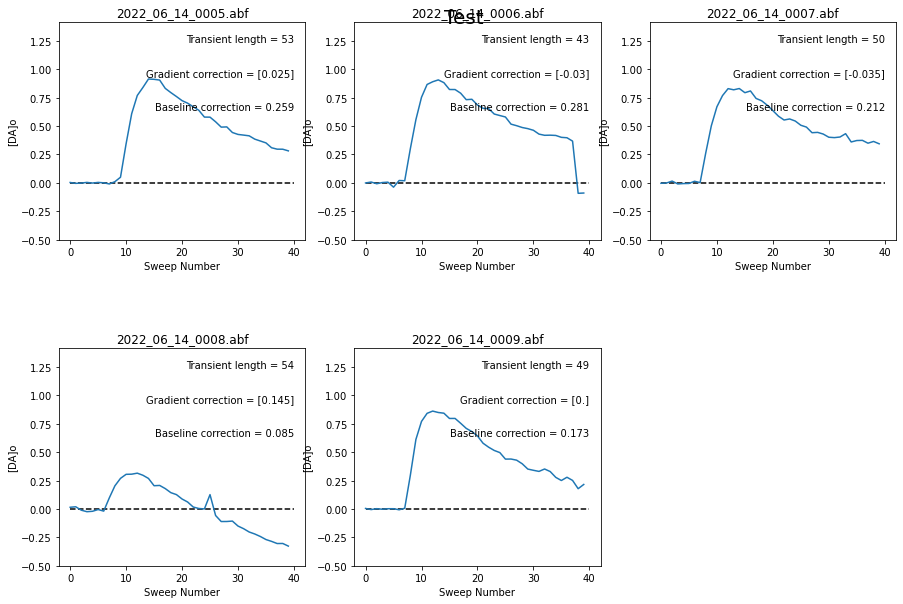

In [32]:
## Plot individual transients

maxvalue = np.max(epochs_baselinecorr)                         # Returns peak value in transient for Y-axis lim

w, h = 5,5
ncols = 3
nrows = int(numEpoch/ncols)+1
plt.figure(figsize = (ncols*w, nrows*h))
plt.subplots_adjust(hspace = 0.5)

for iepoch, epoch in enumerate(epochs_baselinecorr):
    plt.subplot(nrows, ncols, iepoch+1)
    plt.plot(epoch)                                            # Plots correct transient 
    plt.hlines(0, 0, len(epoch), color = 'k', linestyle = 'dashed')
    plt.ylim([-0.5,maxvalue+0.5])
    plt.xlabel('Sweep Number')
    plt.ylabel('[DA]o')
    plt.title(str(DataNames[iepoch]))
    plt.text(sweeplength,maxvalue+0.4,'Transient length = '+str(epoch_length[iepoch]),va='top', ha='right')
    plt.text(sweeplength,maxvalue+0.1,'Gradient correction = '+str(indexes[iepoch]), va='top', ha='right')
    plt.text(sweeplength,maxvalue-0.2,'Baseline correction = '+str(round(Avg_bases[iepoch],3)),va='top', ha='right')
plt.suptitle(Experiment_title, fontsize = 20, y = 0.90)

os.chdir(procDir)

plt.savefig(bsnm+'.Transients.pdf')

os.chdir(homeDir)

plt.show()


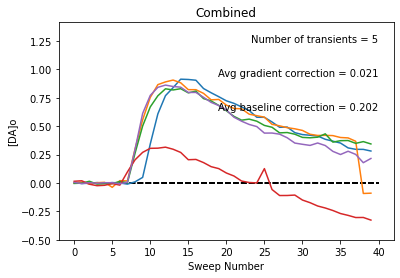

In [33]:
## Plot combined transient alignment

plt.figure()
for iepoch, epoch in enumerate(epochs_baselinecorr):
    plt.plot(epoch) 
    plt.hlines(0, 0, len(epoch), color='k', linestyle='dashed')
    plt.ylim([-0.5,maxvalue+0.5])
    plt.xlabel('Sweep Number')
    plt.title('Combined')
    plt.ylabel('[DA]o')
plt.text(sweeplength,maxvalue+0.4,'Number of transients = '+str(len(epochs_baselinecorr)),va='top', ha='right')
plt.text(sweeplength,maxvalue+0.1,'Avg gradient correction = '+str(round(np.average(indexes),3)),va='top', ha='right')
plt.text(sweeplength,maxvalue-0.2,'Avg baseline correction = '+str(round(np.average(Avg_bases),3)),va='top', ha='right')

os.chdir(procDir)

plt.savefig(bsnm+'.Combined.pdf')

os.chdir(homeDir)


In [28]:
## Save data 

tp_epochs_baselinecorr_info = np.transpose(epochs_baselinecorr_info) # Transposes the dataset

os.chdir(procDir)  

output_file = bsnm+'.DataProcessed.csv'                      # Name extension for processed output file 
np.savetxt(output_file,tp_epochs_baselinecorr_info, delimiter=",", fmt="%s") # Saves output data as .csv

os.chdir(homeDir)

## Creates an output .csv file that contains the different 2.5 min-spaced transients in columns, and 
## timepoints of a single transient in rows.
